# ECE 590, Fall 2019 
## Problem Set 5
 

## Full name: Ana B. Barcenas


In [109]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

### Dataset

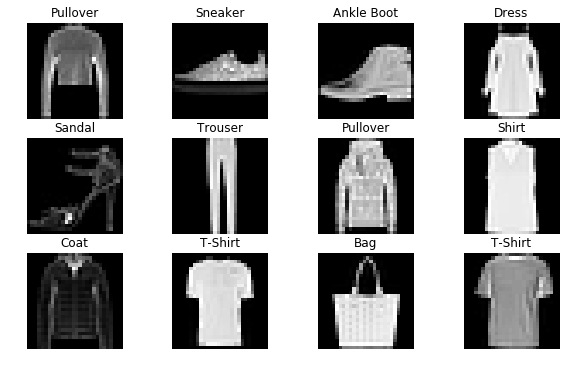

In [90]:
# Download and prepare the Fashion MNIST data set 
batch_size = 100
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = dsets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = dsets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

import matplotlib.pyplot as plt

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(10,6));
columns = 4;
rows = 3;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

### CNN model architecture

In [91]:
def Flatten(x):
    return x.view(x.size()[0], -1)

In [105]:
class CNN_abbj(nn.Module):
    
    # Our batch shape for input x is (1, 28, 28)
    
    def __init__(self, in_channels, out_channels):
        super(CNN_abbj, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                               kernel_size=5, stride=1, padding=0, 
                               bias=True)

        self.fc   = nn.Linear(in_features=10*12*12, out_features=out_channels)
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 2)
        x = Flatten(x)
        x = self.fc(x)
        return x

### Define train() and test() functions

In [106]:
def train(model, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))

def test(model, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, test_loss, 100. * correct / len(test_loader.dataset)))

### Define optimizer ADAM and scheduler()

In [107]:
import torch.optim as optim

def make_optimizer(model, **kwargs):
    optimizer_ADAM = optim.Adam(model.parameters(),lr=kwargs['lr'])
    return optimizer_ADAM

def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

### Define Main()

In [108]:
seed = 1
scheduler_name = 'MultiStepLR'
num_epochs = 10
lr = 0.05
torch.manual_seed(1)
in_channels = 1
out_channels = 10
model = CNN_abbj(in_channels, out_channels)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(model, lr=lr, momentum=0.9, alpha=0.999, eps=10**(-8))
# same result when using: betas=(0.9,0.999) instead.
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, criterion, optimizer, epoch)
    test(model, test_loader, criterion, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 2.4180
Train(1)[50%]: Loss: 0.8599
Test(1): Loss: 0.5154, Accuracy: 81.9000%
Optimizer Learning rate: 0.0500
Train(2)[0%]: Loss: 0.4439
Train(2)[50%]: Loss: 0.4769
Test(2): Loss: 0.5459, Accuracy: 81.8400%
Optimizer Learning rate: 0.0500
Train(3)[0%]: Loss: 0.4733
Train(3)[50%]: Loss: 0.4986
Test(3): Loss: 0.6843, Accuracy: 76.7500%
Optimizer Learning rate: 0.0500
Train(4)[0%]: Loss: 0.7395
Train(4)[50%]: Loss: 0.5748
Test(4): Loss: 0.5650, Accuracy: 79.2400%
Optimizer Learning rate: 0.0500
Train(5)[0%]: Loss: 0.3828
Train(5)[50%]: Loss: 1.3634
Test(5): Loss: 0.6618, Accuracy: 77.7000%
Optimizer Learning rate: 0.0050
Train(6)[0%]: Loss: 0.5027
Train(6)[50%]: Loss: 0.5440
Test(6): Loss: 0.5853, Accuracy: 79.5500%
Optimizer Learning rate: 0.0050
Train(7)[0%]: Loss: 0.5613
Train(7)[50%]: Loss: 0.5015
Test(7): Loss: 0.5668, Accuracy: 80.2500%
Optimizer Learning rate: 0.0050
Train(8)[0%]: Loss: 0.6422
Train(8)[50%]: Loss: 0.4990
Test(8): Loss: 0.5500, Accuracy: 81.1600%


# :)